# Data Analysis

## Preparation

In [1]:
### IMPORTED PACKAGES ###

library(ggplot2) # data visualization
library(tidyverse) # dataset manipulation (includes dplyr)

# PCA calculation and visualization
library(factoextra)
library(FactoMineR)

library(car) # Levene test
library(FSA) # Dunn test

library(vegan) # PERMANOVA

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.1     v stringr   1.5.2
v lubridate 1.9.4     v tibble    3.3.0
v purrr     1.1.0     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some


Registered S3 methods overwritten by 'FSA':
  method       from
  confint.boot car 
  hist.boot    car 

## FSA v0.10.0. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR'

In [2]:
### MAIN DATAFRAMES ###

# load dataset
sharks = read.table("datasets/shark_immunity.txt", header=TRUE, sep="\t")

# change the order the physiological conditions are displayed 
sharks$physiological_condition <- factor(
  sharks$physiological_condition,
  levels = c("Healthy", "Stressed", "Injured", "Infected", "Recovering")
)
# reduces name to just the gene
names(sharks) <- sub("_expression", "", names(sharks))

## Immune Response Profiles of Different Immune Cell Types in Infected Sharks

### Pre-Processing

In [3]:
# healthy and infected population
healthy_infected = sharks %>% filter(physiological_condition %in% c("Healthy", "Infected"))

# group by physiological condition and immune cell type
healthy_infected$group = paste(healthy_infected$physiological_condition, healthy_infected$immune_cell_type, sep="_")

# long dataframe for healthy and infected sharks on immune response metrics
h_inf_immune = healthy_infected %>%
    select(physiological_condition, immune_cell_type, inflammation_level, response_to_infection, immune_receptor_diversity, group) %>%
    
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","group"),
        names_to = "variable",
        values_to = "value"
    )

# inflammation level-specific for healthy and infected sharks 
h_inf_inflam = h_inf_immune[h_inf_immune$variable=="inflammation_level", ]

### self-made functions

In [4]:
# function to check if the pair contained at least 1 NK cell
check_NK_pair = function(pair_lst) {
    not_NK = logical()
    has_NK = logical()
    for (p in pair_lst) {
        ps = str_split_fixed(p, " - ", 2)
        a = str_split_fixed(ps[1], "_", 2)
        b = str_split_fixed(ps[2], "_", 2)
        if (a[2] != "NK_cells" && b[2] != "NK_cells") { not_NK = c(not_NK, TRUE) }
        if (a[2] == "NK_cells" || b[2] == "NK_cells") { has_NK = c(has_NK, TRUE) }

        if (a[2] == "NK_cells" && b[2] == "NK_cells") { print("NK") }
    }
    print(sprintf("%d pairs where p adj < 0.05", length(pair_lst)))
    print(sprintf("%d pairs neither cell type is not an NK cell.", length(not_NK)))
    print(sprintf("%d pairs where at least one cell type is an NK cell.", length(has_NK)))
    
    if (length(has_NK) == length(pair_lst)) { 
        print(sprintf("All pairs where p adj < 0.05 have at least one cell type that is an NK cell."))
    } else { 
        print(sprintf("Not all pairs were p adj < 0.05 have a cell type that is an NK cell."))
    }
}

# function to make a matrix that identifies there is a statistical difference between healthy or infected NK cells and healthy or infected cells of any type
NK_partner_matrix = function(pair_lst) {
    # create lists of "partner" cell types, separating them based on whether they were paired with a healthy or infected NK cell
    healthy_NK = list(); infected_NK = list()
    h = 1; i = 1

    for (p in pair_lst) {
        ps = str_split_fixed(paste(p)," - ",2)
        if (ps[1] == "Healthy_NK_cells") { 
            healthy_NK[[h]] = ps[2]
            h = h + 1
        }
        if (ps[2] == "Healthy_NK_cells") { 
            healthy_NK[[h]] = ps[1]
            h = h + 1
        }
        if (ps[1] == "Infected_NK_cells") { 
            infected_NK[[i]] = ps[2]
            i = i + 1
        }
        if (ps[2] == "Infected_NK_cells") { 
            infected_NK[[i]] = ps[1]
            i = i + 1
        }
    }

    # create sublists of "partner" cell types, separating them further based on whether they themselves were healthy or infected
    healthy_NK_h = list(); healthy_NK_i = list()
    h = 1; i = 1

    for (x in healthy_NK) {
        aux = str_split_fixed(x,"_",2)
        if (aux[1] == "Healthy") { 
            healthy_NK_h[h] = aux[2]
            h = h + 1
        }
        if (aux[2] == "Healthy") { 
            healthy_NK_h[h] = aux[1]
            h = h + 1
        }
        if (aux[1] == "Infected") { 
            healthy_NK_i[i] = aux[2]
            i = i + 1
        }
        if (aux[2] == "Infected") { 
            healthy_NK_i[i] = aux[1]
            i = i + 1
        }
    }

    infected_NK_h = list(); infected_NK_i = list()
    h = 1; i = 1
    for (x in infected_NK) {
        aux = str_split_fixed(x,"_",2)
        if (aux[1] == "Healthy") { 
            infected_NK_h[h] = aux[2]
            h = h + 1
        }
        if (aux[2] == "Healthy") { 
            infected_NK_h[h] = aux[1]
            h = h + 1
        }
        if (aux[1] == "Infected") { 
            infected_NK_i[i] = aux[2]
            i = i + 1
        }
        if (aux[2] == "Infected") { 
            infected_NK_i[i] = aux[1]
            i = i + 1
        }
    }

    # concatenate all the sublists for easy looping
    partner_groups = list(healthy_NK_h, healthy_NK_i, infected_NK_h, infected_NK_i)

    # get all cell types as a list
    cell_types = as.list(unique(sharks$immune_cell_type))

    # check that all the sublists contain all the cell types
    res = logical()
    for (g in partner_groups) {
        for (t in cell_types) {
            res = c(res, t %in% g)
        }
    }

    # create a true-false matrix 
    partner_matrix = matrix(
        res,
        nrow = length(partner_groups),
        ncol = length(cell_types),
        byrow = TRUE
    )
    # left letter represents the NK cell; right letter represents the varying cell type
    rownames(partner_matrix) = c("H - H", "H - I", "I - H", "I - I")
    colnames(partner_matrix) = cell_types

    return(partner_matrix)
}

### PCA 

In [5]:
# PCA on response to infection, inflammation level, and immune receptor diversity metrics
h_inf_pca <- PCA(healthy_infected[c("response_to_infection","inflammation_level","immune_receptor_diversity")], scale.unit=TRUE, graph=FALSE)

### Inflammation Level Profile

In [6]:
# test the normality of distributions
h_inf_inflam %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.90525866
Healthy_Dendritic_cells,0.53154464
Healthy_Macrophages,0.65941410
Healthy_Monocytes,0.41745223
Healthy_NK_cells,0.38072358
Healthy_T_cells,0.46554625
Infected_B_cells,0.52597683
Infected_Dendritic_cells,0.86273029
Infected_Macrophages,0.97692907


In [7]:
# test the homogenity of variances 
leveneTest(data=h_inf_inflam, value ~ group)

Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,11,4.790187,3.89404e-07
,708,NA,NA


#### Kruskal-Wallis & Dunn's Post Hoc Test

In [8]:
# kruskal-wallis test to test if a statistical difference exists at all
h_inf_inflam_kw = kruskal.test(data=healthy_infected, inflammation_level ~ group)
print(h_inf_inflam_kw)


	Kruskal-Wallis rank sum test

data:  inflammation_level by group
Kruskal-Wallis chi-squared = 342.95, df = 11, p-value < 2.2e-16



In [9]:
# dunn test to identify between which pairs a statistical difference exists
h_inf_inflam_dunn = (dunnTest(data=h_inf_inflam, value ~ group, method="holm")$res)

# get the list of pairs that have a p adj value less than 0.05
inflam_diff_res = h_inf_inflam_dunn[h_inf_inflam_dunn$P.adj < 0.05, ]

# get pair names (no need for the p adj value)
inflam_pair_lst = unique(inflam_diff_res$Comparison)

# check that NK cells are actually involved in every pair
check_NK_pair(inflam_pair_lst)

# NK partner matrix for inflammation level
NK_partner_matrix(inflam_pair_lst)


Warning message:
"group was coerced to a factor."


[1] "20 pairs where p adj < 0.05"
[1] "0 pairs neither cell type is not an NK cell."
[1] "20 pairs where at least one cell type is an NK cell."
[1] "All pairs where p adj < 0.05 have at least one cell type that is an NK cell."


,Monocytes,Dendritic_cells,T_cells,NK_cells,B_cells,Macrophages
H - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
H - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
I - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
I - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


### Immune Receptor Diversity Profiles

### Response to Infection Profile

# Analysis of Dataset 3 -- The Fangs of Immunity : Resilience of the Shark Immune System

## Presentation of the Dataset

## Scientific Questions

1. Do the immune reponse profiles differ from one immune cell type to another if a shark is infected? If so, how so?

2. How do the immune genes in case of injury or infection?

## Analytical Approaches and Methods Used

The packages used were ggplot2, tidyverse, factoextra, FactoMineR, car, FSA, and vegan.

Identifying the most pertinent variables and groups by which these variables would be compared was the first step. Preprocessing was then based on specific values from group-defining nominal variables.

`[preprocessing]`

For both questions, a PCA was done on the metrics of interest, preceded by a PERMANOVA for the second question. To choose which tests to perform, the Shapiro-Wilks and the Levene tests were run by group for each metric. To identify for which groups a statistical difference existed, the Kruskal-Wallis and Dunn's post hoc tests were performed for metrics whose distributions or variances were not normal or homogenous, respectively; otherwise, One-Way ANOVA and Tukey HSD tests were used. For all tests, 0.05 was the working alpha threshold. R version 4.5.1 was used for all analysis.

## Results Obtained

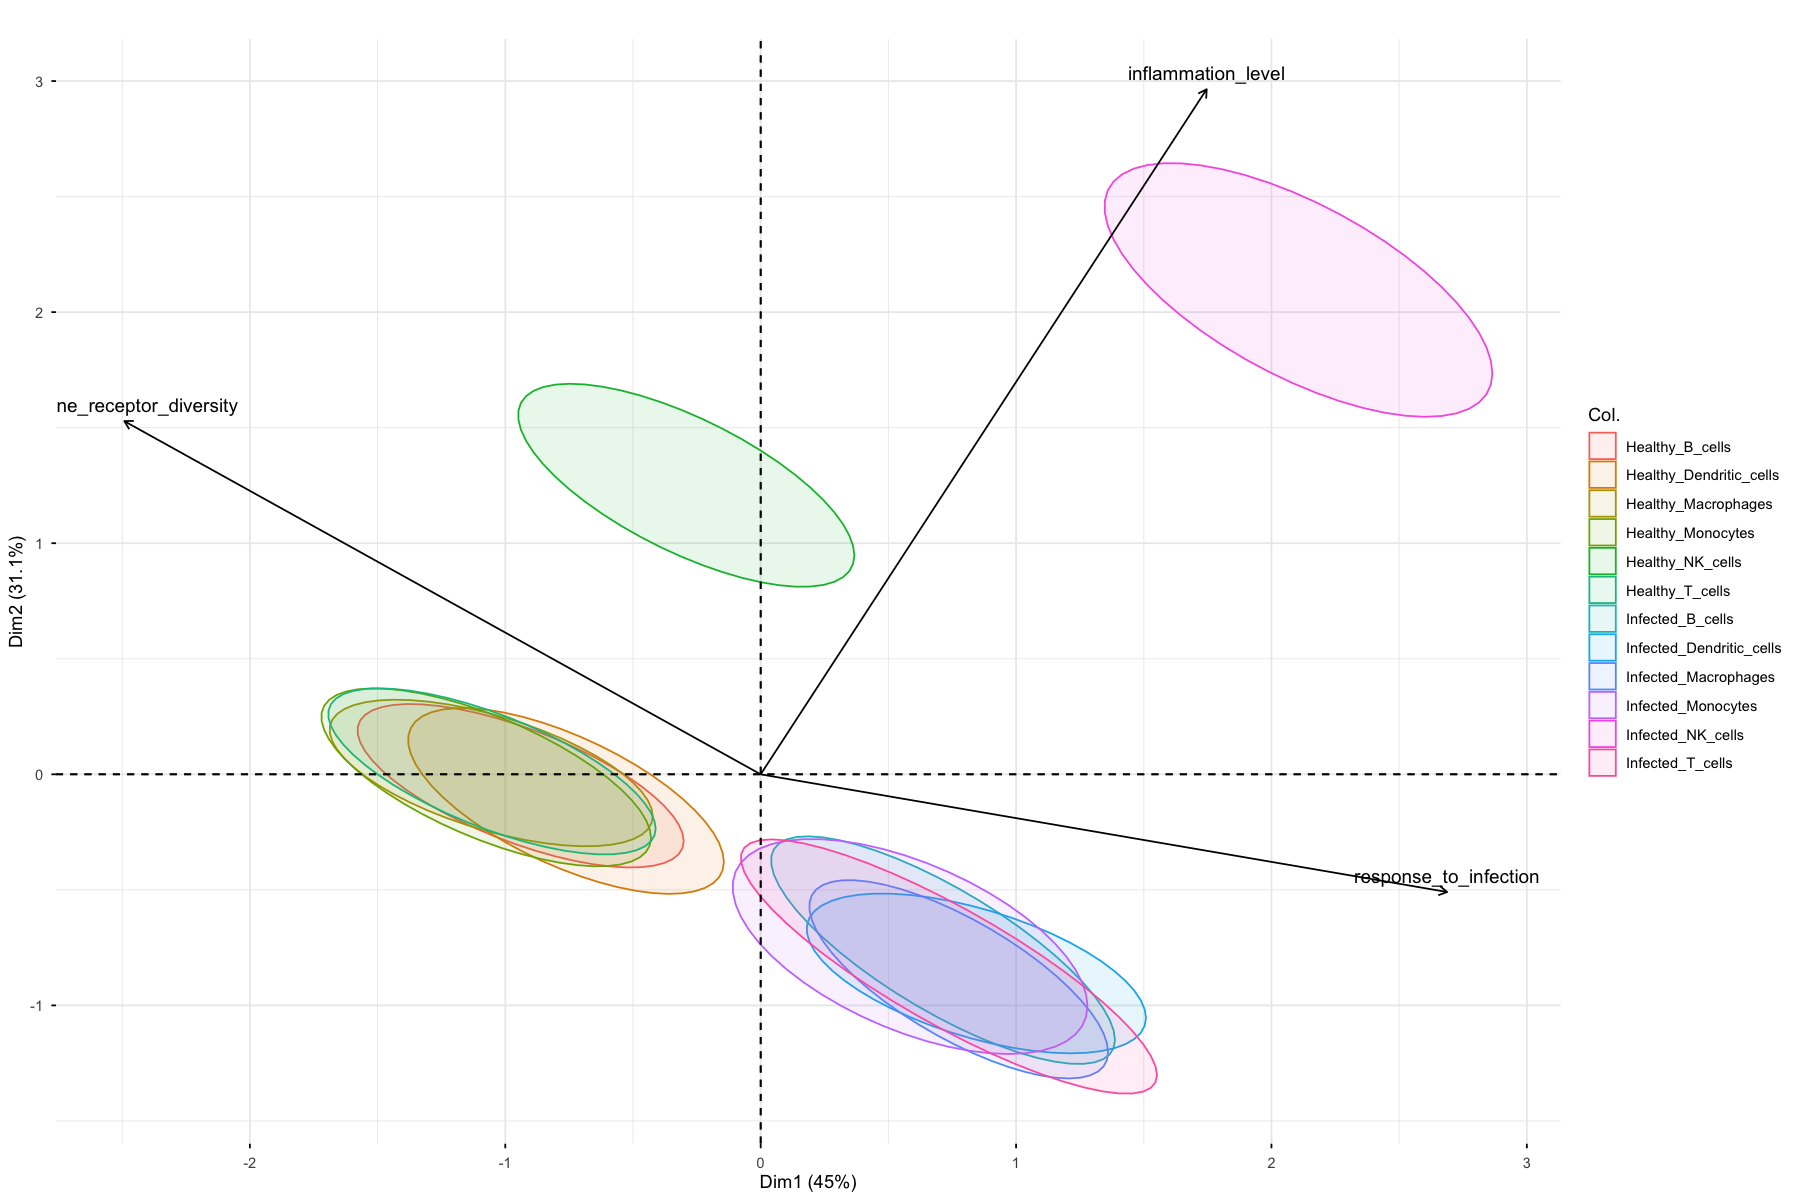

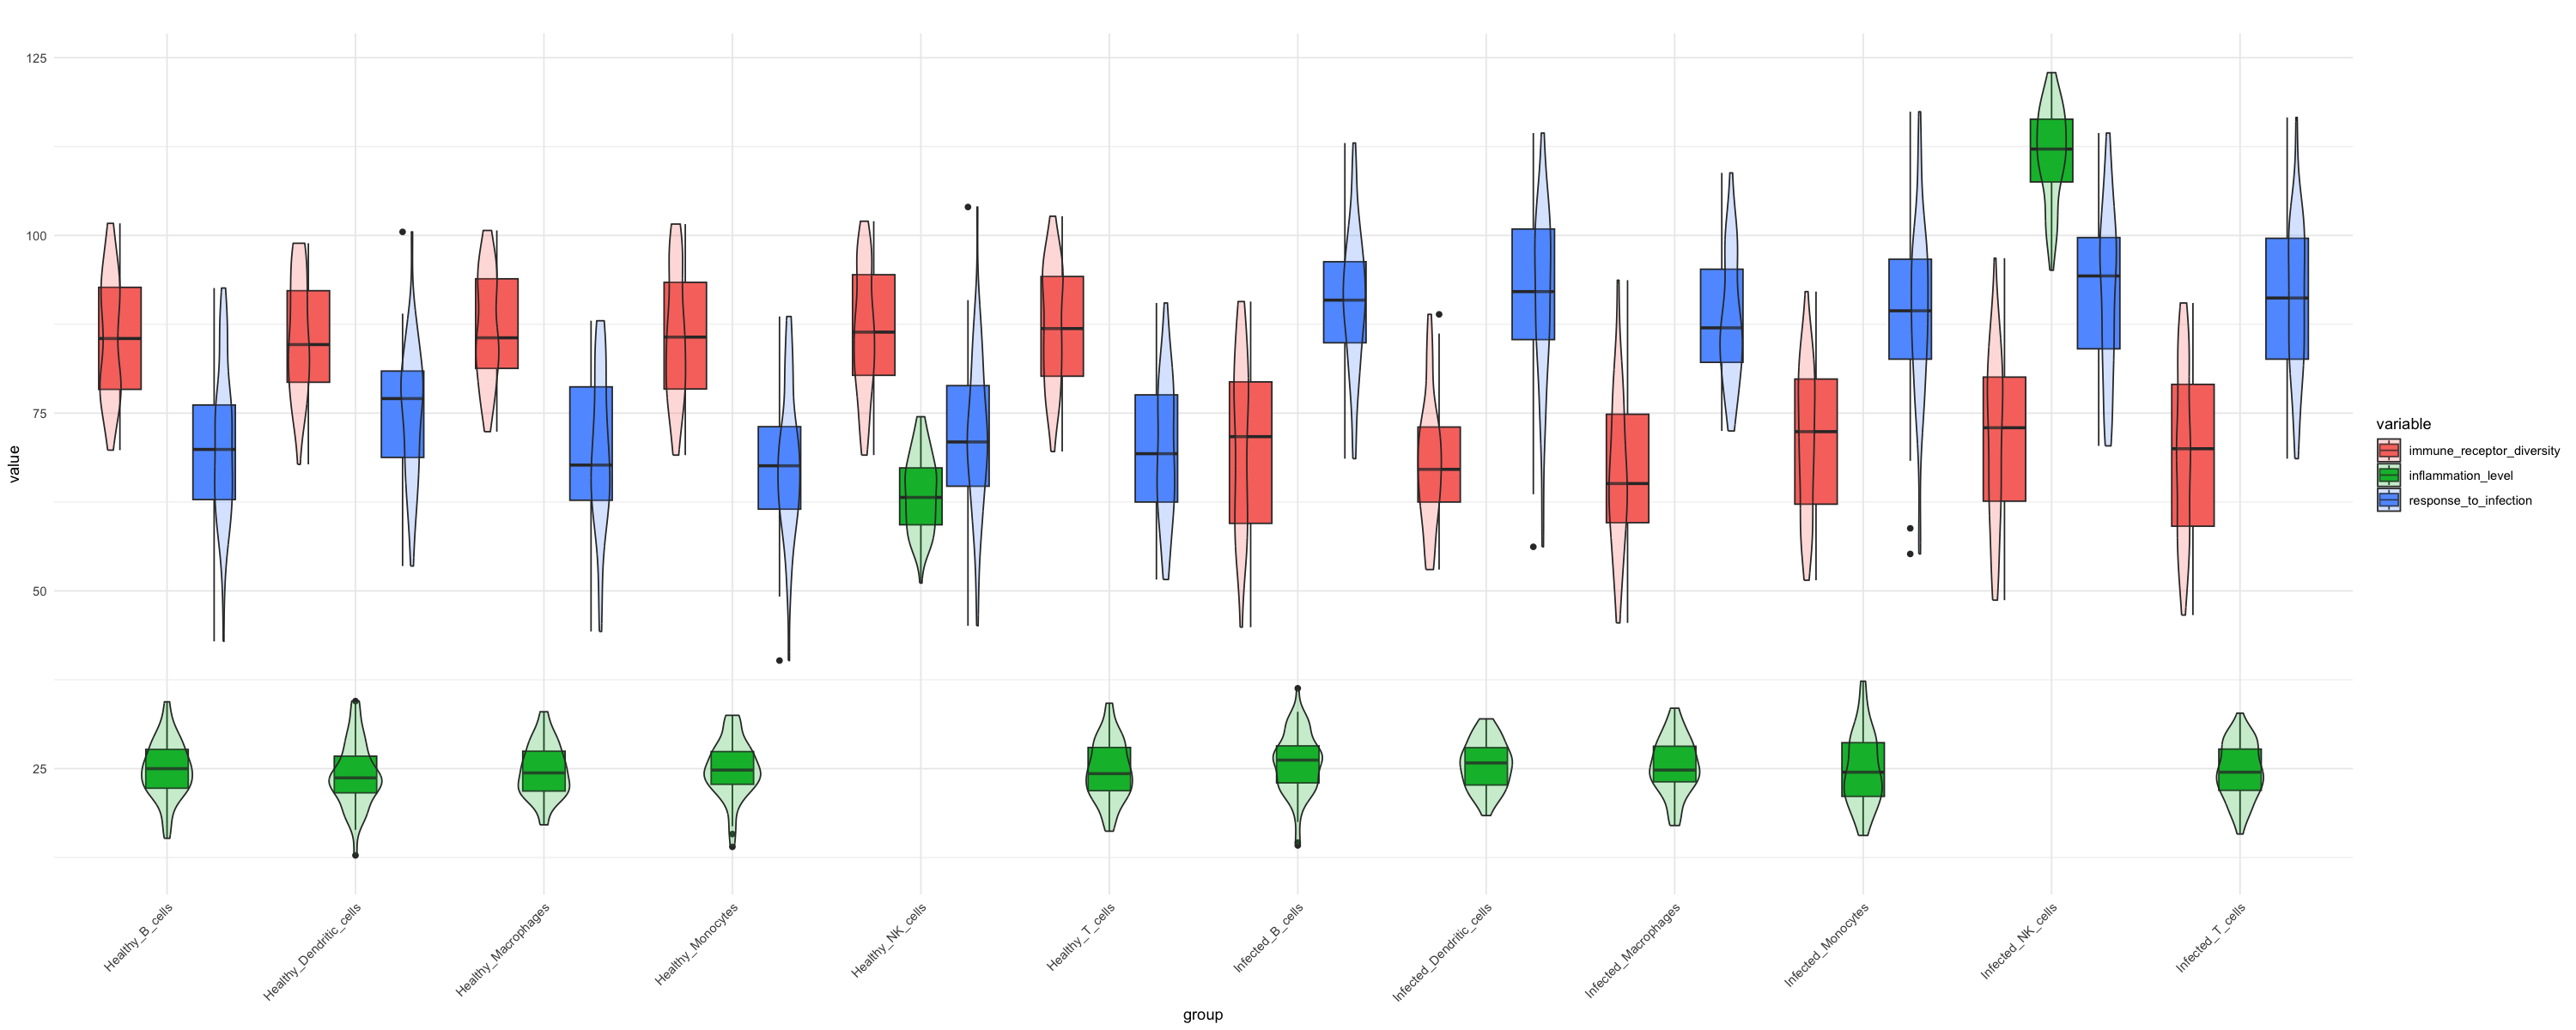

In [14]:
# IMMUNITY METRIC CORRELATIONS FOR EACH IMMUNE CELL TYPE IN EITHER HEALTHY OR INFECTED SHARKS

# customize graph size
options(repr.plot.width=15, repr.plot.height=10)

# MDS cloud plot with correlation circle
fviz_pca_biplot(
    h_inf_pca, geom.ind="None",
    col.ind=healthy_infected$group,
    col.var="black", addEllipses=TRUE,
    ellipse.level=0.5,
    title="Immunity Metric Correlations for Each Immune Cell Type Either Healthy or Infected Sharks") +

    theme(plot.title=element_text(hjust=3)
)

# IMMUNE RESPONSE LEVELS ACROSS IMMUNE CELL TYPES IN HEALTHY AND INFECTED SHARKS

# customize graph size
options(repr.plot.width=25, repr.plot.height=10)

# boxplot
ggplot(h_inf_immune, aes(x=group, y=value, fill=variable)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        axis.text.x=element_text(angle=45, hjust=1),
        plot.title=element_text(hjust=3)
    ) +
    ggtitle("Immune Response Levels Across Immune Cell Types in Healthy and Infected Sharks")

The PCA shows that what differs in healthy and infected sharks is their opposite responses in terms of response to infection and immune receptor diversity; healthy sharks have lower response to infection and higher immune receptor diversity while the opposite is true for infected sharks. Additionally, NK cells are distinct from all other cell types by their higher inflammation level, regardless of physiological condition.

As all the p-values for each group were greater than 0.05, the Shapiro-Wilks test confirmed that the inflammation levels were normally distributed for each immune cell type in either healthy or infected sharks. However, the p-value for the Levene test was less than 0.05, being $3.894 \cdot 10^{-7}$ and indicating that the variances were not homogeneous.

The p-value for the Kruskal-Wallis test, $2.2 \cdot 10^{16}$, was less than 0.05, confirming that there was a statistical difference between the groups. Pairs comprising of cells of either physiological condition and type that had a Dunn's post hoc test p-value less than 0.05 were selected, resulting in 20 pairs. All pairs had the NK cell as one cell type. In fact, the results showed that between healthy or infected NK cells and healthy or infected cells of any other type, there was a statistical difference in inflammation level. Recalling the boxplot, this confirms that the NK cells' elevated inflammation level compared to all other cell types, regardless of physiological condition, is significant. Therefore, they specifically are responsible for inflammation in the immune response.

## Conclusion